In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


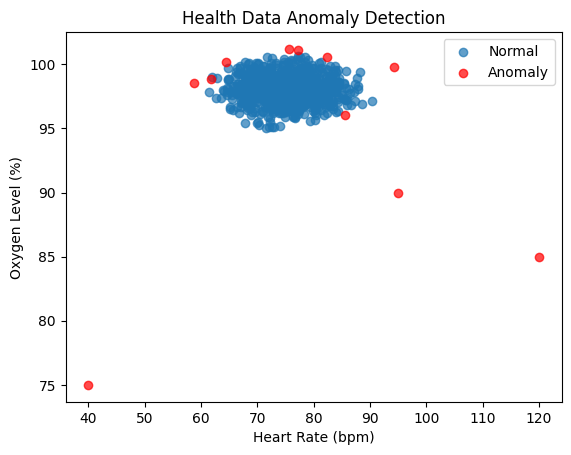

In [2]:
import numpy as np

import pandas as pd

from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt



# Simulate wearable device data

np.random.seed(42)

data = {

    "heart_rate": np.random.normal(75, 5, 1000),  # Normal heart rate: 75 ± 5 bpm

    "oxygen_level": np.random.normal(98, 1, 1000),  # Normal SpO2: 98 ± 1%

}



# Add some anomalies (e.g., health deterioration)

anomalies = pd.DataFrame({

    "heart_rate": [120, 40, 95],  # High or low heart rates

    "oxygen_level": [85, 75, 90],  # Low oxygen levels

})



# Combine data

health_data = pd.DataFrame(data)

health_data = pd.concat([health_data, anomalies], ignore_index=True)



# Train an Isolation Forest

clf = IsolationForest(contamination=0.01, random_state=42)

clf.fit(health_data)



# Predict anomalies

health_data['anomaly'] = clf.predict(health_data)



# Separate normal and anomalous data

normal_data = health_data[health_data['anomaly'] == 1]

anomalous_data = health_data[health_data['anomaly'] == -1]



# Plot the data

plt.scatter(normal_data['heart_rate'], normal_data['oxygen_level'], label='Normal', alpha=0.7)

plt.scatter(anomalous_data['heart_rate'], anomalous_data['oxygen_level'], color='red', label='Anomaly', alpha=0.7)

plt.xlabel('Heart Rate (bpm)')

plt.ylabel('Oxygen Level (%)')

plt.title('Health Data Anomaly Detection')

plt.legend()

plt.show()